# Deep Learning Term Project for ECG (DIL700)

# Iteration 5

## Imports

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.utils import class_weight
import warnings
import os
from general_functions import *
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint


warnings.filterwarnings('ignore')

## Loading Dataset

Collect all the data from the csv files

In [47]:
# # Original data

train_df=combine_csv_files_to_df('./Dataset_mitbih/Training/')
test_df=combine_csv_files_to_df('./Dataset_mitbih/Testing/')
# Put together the training and testing
# Read csv file into df
df_generated = pd.read_csv('./Dataset_mitbih/Synthetic/generated_samples.csv', header=None)
df_generated = df_generated[df_generated[187] != 187]
full_df=pd.concat([train_df,test_df,df_generated],ignore_index=True)

# Synthetic data

# train_df = pd.read_csv('./Dataset_mitbih/Synthetic/mitbih_with_syntetic_train.csv')
# train_df = train_df.iloc[:, :-1]
# train_df.rename(columns={'class': 187}, inplace=True)
# test_df = pd.read_csv('./Dataset_mitbih/Synthetic/mitbih_with_syntetic_test.csv')
# test_df = test_df.iloc[:, :-1]
# test_df.rename(columns={'class': 187}, inplace=True)

# # Put together the training and testing
# full_df=pd.concat([train_df,test_df],ignore_index=True)


## Removing class 3 and renaming class 4 to class 3

In [48]:
train_df = train_df[train_df[187] != 3]
test_df = test_df[test_df[187] != 3]
full_df = full_df[full_df[187] != 3]

train_df = train_df[train_df[187] != '3.0']
test_df = test_df[test_df[187] != '3.0']
full_df = full_df[full_df[187] != '3.0']

train_df = train_df[train_df[187] != 'class']
test_df = test_df[test_df[187] != 'class']
full_df = full_df[full_df[187] != 'class']

train_df.loc[train_df[187] == 4, 187] = 3.0
test_df.loc[test_df[187] == 4, 187] = 3.0
full_df.loc[full_df[187] == 4, 187] = 3.0

train_df.loc[train_df[187] == '4.0', 187] = 3.0
test_df.loc[test_df[187] == '4.0', 187] = 3.0
full_df.loc[full_df[187] == '4.0', 187] = 3.0

train_df.loc[train_df[187] == '0.0', 187] = 0.0
train_df.loc[train_df[187] == '1.0', 187] = 1.0
train_df.loc[train_df[187] == '2.0', 187] = 2.0
train_df.loc[train_df[187] == '3.0', 187] = 3.0

In [49]:
print(train_df[187].unique())

[0. 1. 2. 3.]


In [50]:
labels = ['Normal', 'Artial Premature', 'Premature ventricular contraction', 'Paced']
labels_short =  ["N","S","V","Q"]

In [51]:
print('Number of samples in data:')
print(labels[0],':', len(train_df[train_df[187]==0]))
print(labels[1],':', len(train_df[train_df[187]==1]))
print(labels[2],':', len(train_df[train_df[187]==2]))
print(labels[3],':', len(train_df[train_df[187]==3]))

Number of samples in data:
Normal : 72471
Artial Premature : 2223
Premature ventricular contraction : 5788
Paced : 6431


In [52]:
print('Number of samples in data:')
print(labels[0],':', len(test_df[test_df[187]==0]))
print(labels[1],':', len(test_df[test_df[187]==1]))
print(labels[2],':', len(test_df[test_df[187]==2]))
print(labels[3],':', len(test_df[test_df[187]==3]))

Number of samples in data:
Normal : 18118
Artial Premature : 556
Premature ventricular contraction : 1448
Paced : 1608


## Preparation

In [53]:
X = full_df.iloc[:, :-1]
y = full_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=82)

y_train_nn = pd.get_dummies(y_train, columns=[1])
y_train_nn = y_train_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "Q"})

y_valid_nn = pd.get_dummies(y_valid, columns=[1])
y_valid_nn = y_valid_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "Q"})

y_test_nn = pd.get_dummies(y_test, columns=[1])
y_test_nn = y_test_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "Q"})

In [54]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
59843,0.945455,0.750000,0.389394,0.068182,0.000000,0.083333,0.062121,0.043939,0.039394,0.030303,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
114937,0.964755,0.996982,0.357728,-0.029199,0.044256,0.120795,0.136079,0.142229,0.192376,0.200923,...,0.001839,0.007355,0.008851,0.006831,0.002531,0.01273,-0.001091,-0.005465,-0.003194,0.004376
75944,0.894231,0.973558,0.951923,0.891827,0.838942,0.814904,0.802885,0.807692,0.617788,0.326923,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
102856,1.000000,0.832432,0.302703,0.037838,0.062162,0.078378,0.043243,0.013514,0.021622,0.013514,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
96529,1.000000,0.952459,0.681967,0.414754,0.365574,0.357377,0.324590,0.309836,0.303279,0.301639,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11888,1.000000,0.958159,0.615063,0.305439,0.000000,0.083682,0.062762,0.230126,0.317992,0.309623,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
65575,0.973333,0.800000,0.128889,0.200000,0.133333,0.102222,0.048889,0.066667,0.044444,0.080000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
107246,0.993827,1.000000,0.901235,0.691358,0.703704,0.753086,0.783951,0.691358,0.604938,0.512346,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
76687,0.532468,0.406308,0.231911,0.100186,0.001855,0.000000,0.022263,0.024119,0.063080,0.115028,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


In [55]:
y_train

59843     0.0
114937    1.0
75944     2.0
102856    0.0
96529     0.0
         ... 
11888     0.0
65575     0.0
107246    2.0
76687     2.0
20723     0.0
Name: 187, Length: 74651, dtype: float64

In [56]:
y_train_nn

,N,S,V,Q
59843,1,0,0,0
114937,0,1,0,0
75944,0,0,1,0
102856,1,0,0,0
96529,1,0,0,0
...,...,...,...,...
11888,1,0,0,0
65575,1,0,0,0
107246,0,0,1,0
76687,0,0,1,0


In [57]:
X_valid

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
104947,0.946037,0.898820,0.580101,0.175379,0.160202,0.205734,0.180438,0.165261,0.163575,0.160202,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70863,1.000000,0.891544,0.645221,0.397059,0.167279,0.068015,0.069853,0.084559,0.113971,0.136029,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56902,0.947195,0.768977,0.402640,0.138614,0.122112,0.085809,0.072607,0.042904,0.042904,0.026403,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61786,1.000000,0.698864,0.102273,0.156250,0.147727,0.150568,0.142045,0.142045,0.144886,0.147727,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44079,1.000000,0.869023,0.609148,0.255717,0.124740,0.074844,0.047817,0.022869,0.010395,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75132,0.000000,0.018933,0.141136,0.261618,0.378657,0.437177,0.504303,0.566265,0.607573,0.688468,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97951,0.000000,0.102500,0.220000,0.365000,0.425000,0.530000,0.635000,0.695000,0.682500,0.702500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26161,0.979508,0.868852,0.604508,0.348361,0.131148,0.043033,0.038934,0.055328,0.061475,0.065574,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23358,0.176101,0.000000,0.147799,0.251572,0.339623,0.389937,0.367925,0.358491,0.393082,0.402516,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dataset Distribution

### Training set

In [58]:
y_train=y_train.astype(int)
equilibre_train=y_train.value_counts(sort=False)
print(equilibre_train)

0    58004
1     6807
2     4680
3     5160
Name: 187, dtype: int64


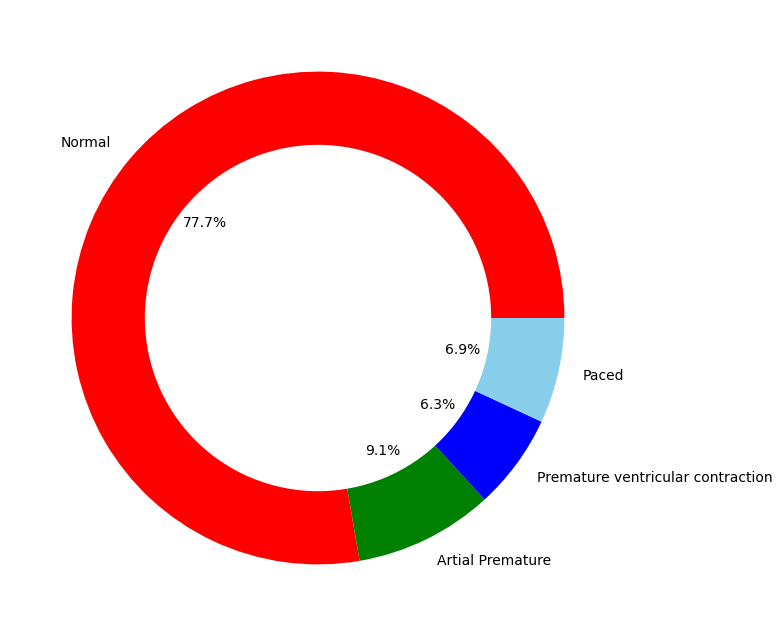

In [59]:
plt.figure(figsize=(8,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre_train, labels= labels
        , colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### Testing set

In [60]:
y_test=y_test.astype(int)
equilibre_test=y_test.value_counts(sort=False)
print(equilibre_test)

0    18078
3     1582
1     2220
2     1449
Name: 187, dtype: int64


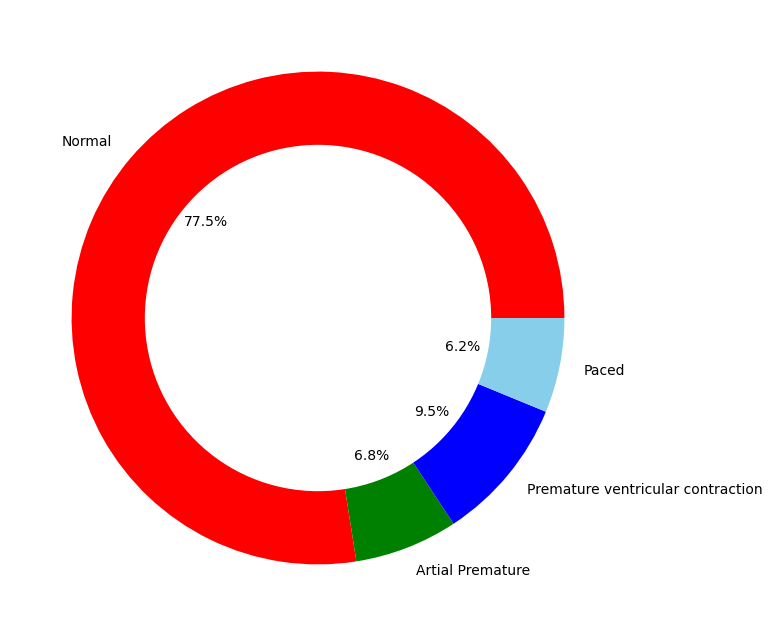

In [61]:
plt.figure(figsize=(8,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre_test, labels= labels
        , colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

## Simple ANN

In [ ]:
model_ann = Sequential([
    Dense(256, activation='relu', input_dim=(X_train.shape[1])),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

model_ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_ann_5.h5', monitor='val_loss', save_best_only=True)]


history_ann = model_ann.fit(X_train, y_train_nn, epochs=40, callbacks=callbacks, batch_size=32, validation_data=(X_valid, y_valid_nn))
model_ann.load_weights('best_ann_5.h5')
save_model(model_ann, 'ANN_MITBIH_with_GAN_Data', 'keras')

In [ ]:
history_df_ann = pd.DataFrame(history_ann.history)
history_df_ann.index += 1

cols = ['loss', 'val_loss']

plt.figure()
plt.plot(history_df_ann[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Loss - ANN")
plt.legend(cols, loc="right")
plt.show()

In [ ]:
cols = ['accuracy', 'val_accuracy']

plt.figure()
plt.plot(history_df_ann[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Accuracy - ANN")
plt.legend(cols, loc="right")
plt.show()

In [ ]:
# Predict test set labels
y_pred_1  = model_ann.predict(X_test)
y_pred_ann = np.argmax(y_pred_1 , axis=1)

print('Accuracy of ANN: ', accuracy_score(y_test, y_pred_ann))

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_ann)

# Plot confusion matrix
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix ANN')
ax.xaxis.set_ticklabels(labels_short)
ax.yaxis.set_ticklabels(labels_short)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_ann, target_names=labels, digits=4))

## CNN

In [62]:
model_cnn = Sequential([
    Conv1D(64, kernel_size=6, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=3, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_cnn_5.h5', monitor='val_loss', save_best_only=True)]


history_cnn = model_cnn.fit(X_train, y_train_nn, epochs=40, callbacks=callbacks, batch_size=32, validation_data=(X_valid, y_valid_nn))

model_cnn.load_weights('best_cnn_5.h5')
# save_model(model_cnn, 'CNN_MITBIH_with_GAN_Data', 'keras')

Epoch 1/40
2333/2333 [==============================] - 24s 9ms/step - loss: 0.1250 - accuracy: 0.9644 - val_loss: 0.1314 - val_accuracy: 0.9626
Epoch 2/40
2333/2333 [==============================] - 20s 9ms/step - loss: 0.0717 - accuracy: 0.9797 - val_loss: 0.0729 - val_accuracy: 0.9785
Epoch 3/40
2333/2333 [==============================] - 20s 9ms/step - loss: 0.0569 - accuracy: 0.9838 - val_loss: 0.0805 - val_accuracy: 0.9760
Epoch 4/40
2333/2333 [==============================] - 20s 9ms/step - loss: 0.0480 - accuracy: 0.9859 - val_loss: 0.0694 - val_accuracy: 0.9784
Epoch 5/40
2333/2333 [==============================] - 20s 9ms/step - loss: 0.0416 - accuracy: 0.9877 - val_loss: 0.1103 - val_accuracy: 0.9614
Epoch 6/40
2333/2333 [==============================] - 19s 8ms/step - loss: 0.0369 - accuracy: 0.9890 - val_loss: 0.0554 - val_accuracy: 0.9842
Epoch 7/40
2333/2333 [==============================] - 20s 9ms/step - loss: 0.0328 - accuracy: 0.9894 - val_loss: 0.0502 - val_ac

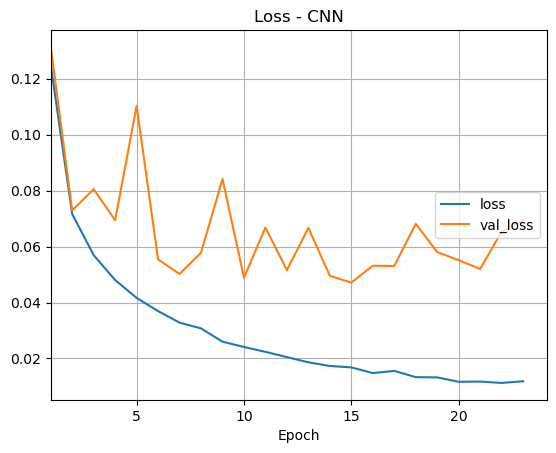

In [63]:
history_df_cnn = pd.DataFrame(history_cnn.history)
history_df_cnn.index += 1

cols = ['loss', 'val_loss']

plt.figure()
plt.plot(history_df_cnn[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Loss - CNN")
plt.legend(cols, loc="right")
plt.show()

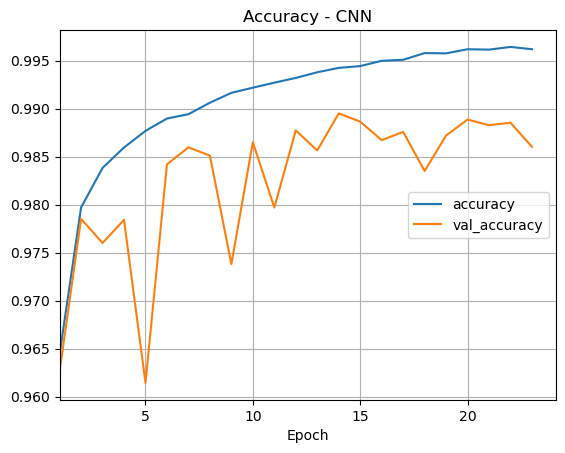

In [64]:
cols = ['accuracy', 'val_accuracy']

plt.figure()
plt.plot(history_df_cnn[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Accuracy - CNN")
plt.legend(cols, loc="right")
plt.show()

In [65]:
# Predict test set labels
y_pred_2  = model_cnn.predict(X_test)
y_pred_cnn = np.argmax(y_pred_2 , axis=1)

print('Accuracy of CNN: ', accuracy_score(y_test, y_pred_cnn))

730/730 [==============================] - 2s 2ms/step
Accuracy of CNN:  0.9898838355694629


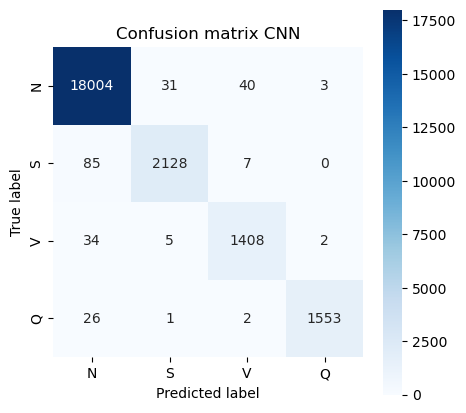

In [66]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_cnn)

# Plot confusion matrix
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix CNN')
ax.xaxis.set_ticklabels(labels_short)
ax.yaxis.set_ticklabels(labels_short)
plt.show()

In [67]:
report = classification_report(y_test, y_pred_cnn, target_names=labels, digits=4)
print(report)

                                   precision    recall  f1-score   support

                           Normal     0.9920    0.9959    0.9940     18078
                 Artial Premature     0.9829    0.9586    0.9706      2220
Premature ventricular contraction     0.9664    0.9717    0.9690      1449
                            Paced     0.9968    0.9817    0.9892      1582

                         accuracy                         0.9899     23329
                        macro avg     0.9845    0.9770    0.9807     23329
                     weighted avg     0.9899    0.9899    0.9899     23329



In [68]:
# model_cnn.load_weights('best_cnn_5.h5')
# save_model(model_cnn, 'CNN_MITBIH_with_GAN_Data', 'keras', report)